In [1]:
from CookieTTS._2_ttm.flowtts.model import FlowTTS
from CookieTTS._2_ttm.flowtts.model import load_model
from CookieTTS._2_ttm.flowtts.hparams import create_hparams
from CookieTTS.utils.audio.stft import TacotronSTFT, STFT
from CookieTTS.utils.text import text_to_sequence

import sys
sys.path.append('../_4_mtw/waveglow') # add WaveGlow to System path for easier importing
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, title=None, figsize=(20, 3.5)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if title:
            axes[i].set_title(title[i])
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [3]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Speaker ID = tensor([5], device='cuda:0')
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_1000
On iter 1000
Text: `printing,`          [mean -5.286242] [max 5.695896] [min -15.170380]
Text: `esssssssssss`       [mean -5.338587] [max 4.237934] [min -13.601327]
Text: `It's been a long time since I've been able to make a Google account without a phone number.` [mean -5.175377] [max 7.460392] [min -14.170756]
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model
On iter 7750
Text: `printing,`          [mean -5.433210] [max 1.473654] [min -10.389177]
Text: `esssssssssss`       [mean -5.275552] [max 2.644270] [min -10.952135]
Text: `It's been a long time since I've been able to make a Google account without a phone number.` [mean -5.275491] [max 2.653858] [min -10.550266]


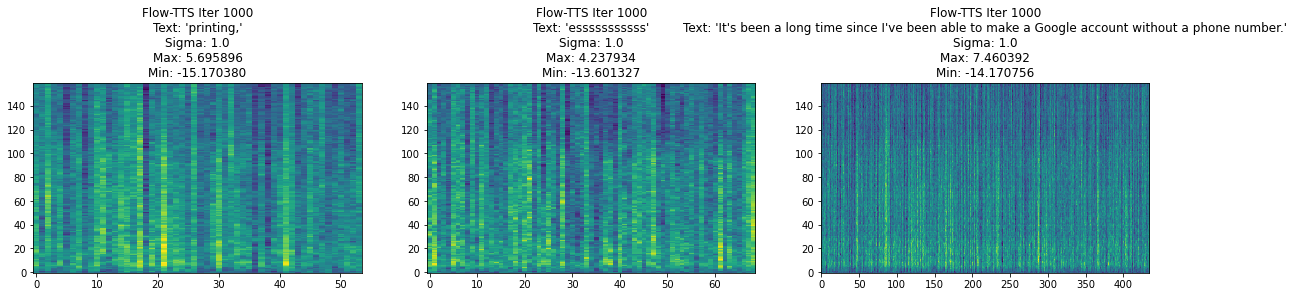

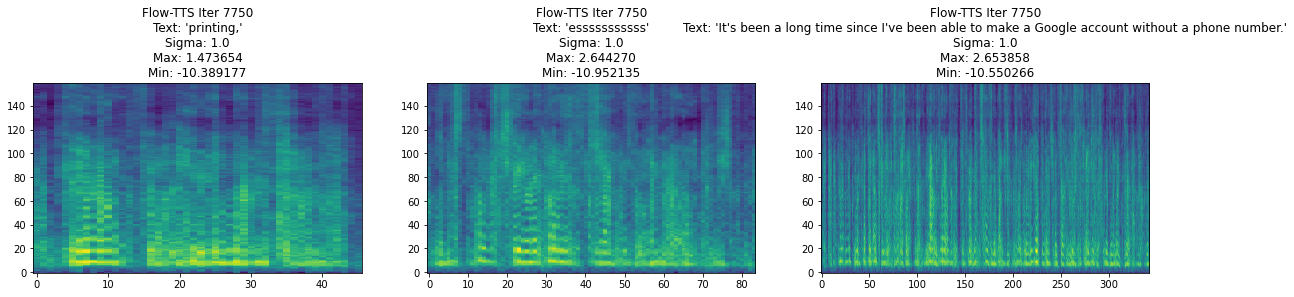

In [4]:
checkpoint_paths = [
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_1000",
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model",
]

texts = [
    "printing,",
    "esssssssssss",
    "It's been a long time since I've been able to make a Google account without a phone number.",
]

sigma = [1.0,]

# Speaker IDs
speaker_ids = torch.LongTensor([5,]).cuda()
print('Speaker ID =', speaker_ids)
# Generate
with torch.no_grad():
    for sigma_ in sigma:
        for i, checkpoint_path in enumerate(checkpoint_paths):
            print(checkpoint_path)
            checkpoint = torch.load(checkpoint_path)
            iteration = checkpoint['iteration']
            print(f"On iter {iteration}")
            model = load_model(hparams)
            model.load_state_dict(checkpoint['state_dict'])
            _ = model.cuda().eval()
            mel_outputs = []
            alignments = []
            titles=[]
            for text in texts:
                sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
                sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                mel_output, alignment, *_ = model.inference(sequence, speaker_ids, sigma=sigma_)
                mel_output = (mel_output-3.5)*8 # inverse transform magnitudes from -1 -> 1 to -11.5 -> 4.5
                alignment = alignment.transpose(-2, -1) if alignment is not None else None
                print(f'Text: {"`"+text+"`":20} [mean {mel_output.mean().item():.6f}] [max {mel_output.max().item():.6f}] [min {mel_output.min().item():.6f}]')
                mel_outputs.append(mel_output)
                alignments.append(alignment)
                titles.append(f"Flow-TTS Iter {iteration}\nText: '{text}'\nSigma: {sigma_}\nMax: {mel_output.max().item():.6f}\nMin: {mel_output.min().item():.6f}")
            plot_data((*[x.float().cpu().numpy()[0] for x in mel_outputs],), title=titles)
            if 1 and alignments[0] is not None:
                if len(alignments[0].shape) == 4:
                    for head_id in range(alignments[0].shape[1]):
                        plot_data((*[x[0][head_id].float().cpu().numpy() for x in alignments],), title=[f'head: {head_id}',]*len(alignments), figsize=(20, 2))
                else:
                    plot_data((*[x[0].float().cpu().numpy() for x in alignments],), figsize=(20, 2))

torch.Size([1, 512, 16])


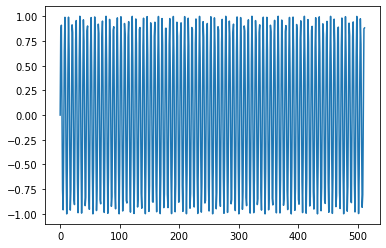

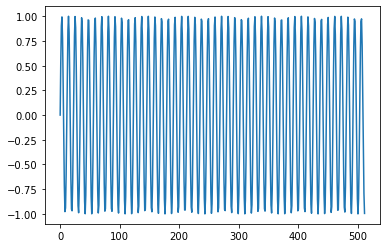

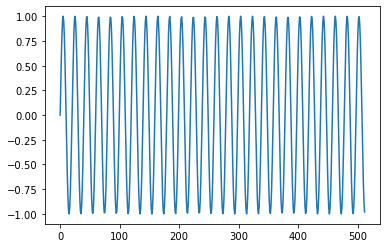

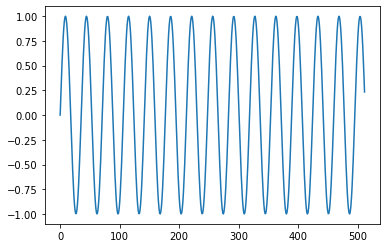

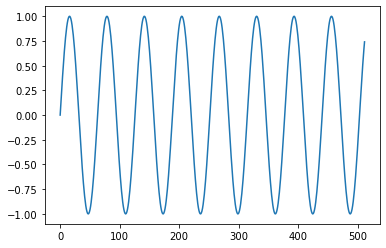

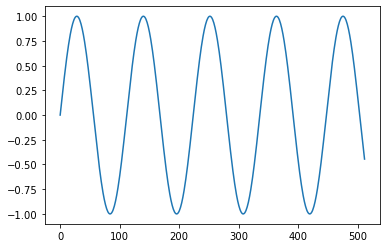

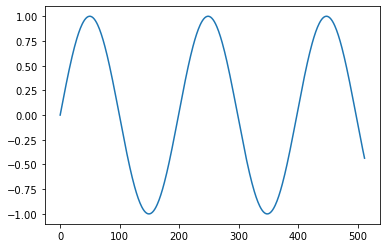

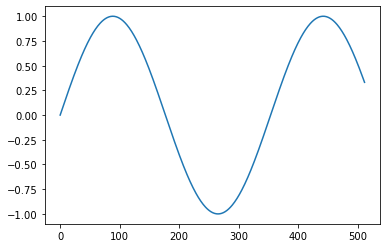

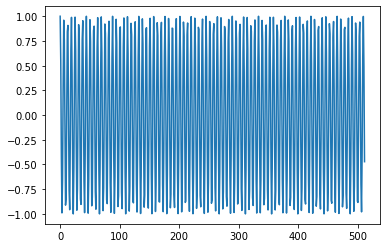

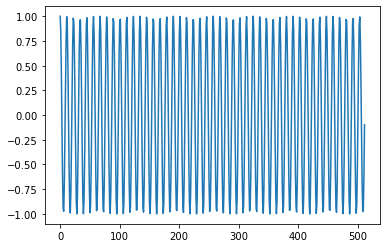

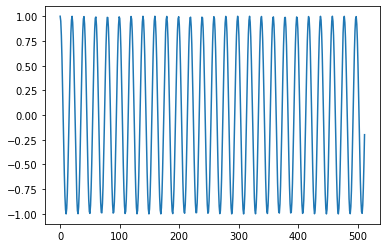

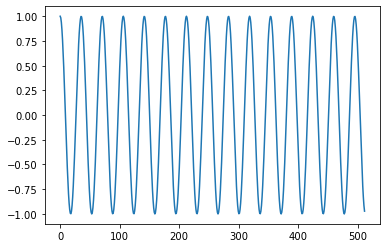

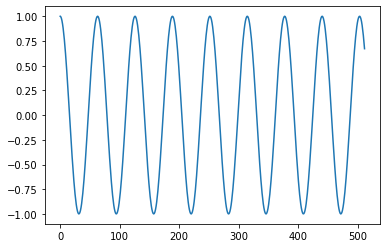

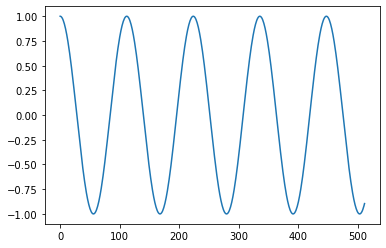

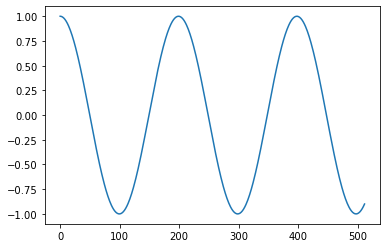

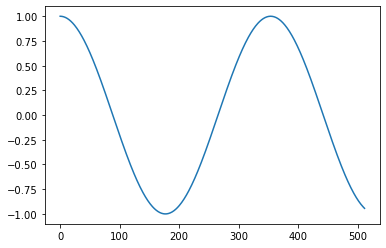

In [143]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

bsz = 1
demb = 16
range_scaler = torch.ones((1,))

inv_freq = torch.tensor(100)
pos_seq = torch.arange(0,512).float()

freq_seq = (torch.arange(0.0, demb, 2.0).unsqueeze(0)*range_scaler.unsqueeze(1)) / demb
inv_freq = 1 / (inv_freq.double() ** freq_seq.double())# [B, dim//2] # warning (to self)! this operation may go INF with very large 'frame per char' values! Keep inv_freq low or use full precision for this part
assert not (inv_freq==0).any(), 'zeros found in inv_freq'

pos_seq = pos_seq.expand(bsz, -1).unsqueeze(-1)# [dec_T]     -> [B, dec_T, 1]
inv_freq = inv_freq.unsqueeze(1)               # [B, dim//2] -> [B, 1, dim//2]
sinusoid_inp = pos_seq.to(inv_freq) @ inv_freq # [B, dec_T, 1] @ [B, 1, dim//2] -> [B, dec_T, dim//2]
pos_emb = torch.cat([sinusoid_inp.sin().to(pos_seq), sinusoid_inp.cos().to(pos_seq)], dim=-1)# [B, dec_T, dim//2] -> [B, dec_T, dim] OR [dec_T, dim//2] -> [dec_T, dim]

print(pos_emb.shape)

for i in range(pos_emb.shape[0]):
    for j in range(pos_emb.shape[2]):
        plt.plot(pos_emb[i,:,j].numpy())
        plt.show()